<a href="https://colab.research.google.com/github/mhdhafil/Cryptocurrency-time-series-forecasting/blob/main/lstmtimeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series Bitcoin price forecasting using LSTM

importing required libraries

In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

fetching dataset from cryptocampare.com using api

In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [ ]:
res.content

b'{"Response":"Success","Type":100,"Aggregated":false,"TimeTo":1651190400,"TimeFrom":1607990400,"FirstValueInArray":true,"ConversionType":{"type":"direct","conversionSymbol":""},"Data":[{"time":1607990400,"high":24964.65,"low":24313.69,"open":24663.8,"volumefrom":81.42,"volumeto":2014729.81,"close":24778.67,"conversionType":"direct","conversionSymbol":""},{"time":1608076800,"high":27554.68,"low":24607.81,"open":24778.67,"volumefrom":200.93,"volumeto":5265256.22,"close":27337.58,"conversionType":"direct","conversionSymbol":""},{"time":1608163200,"high":30240.45,"low":27240.89,"open":27337.58,"volumefrom":262.97,"volumeto":7563315.76,"close":29133.1,"conversionType":"direct","conversionSymbol":""},{"time":1608249600,"high":29667.49,"low":28524.27,"open":29133.1,"volumefrom":100.55,"volumeto":2931958.07,"close":29593.93,"conversionType":"direct","conversionSymbol":""},{"time":1608336000,"high":30577.84,"low":28718.89,"open":29593.93,"volumefrom":106.37,"volumeto":3167114.86,"close":30370.

In [ ]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [ ]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-12-15,24964.65,24313.69,24663.80,81.42,2014729.81,24778.67
2020-12-16,27554.68,24607.81,24778.67,200.93,5265256.22,27337.58
2020-12-17,30240.45,27240.89,27337.58,262.97,7563315.76,29133.10
2020-12-18,29667.49,28524.27,29133.10,100.55,2931958.07,29593.93
2020-12-19,30577.84,28718.89,29593.93,106.37,3167114.86,30370.05


In [ ]:
#function for splitting dataset into training set and testing set
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
#ploting a graph of cryptocurrency price as a function of time
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

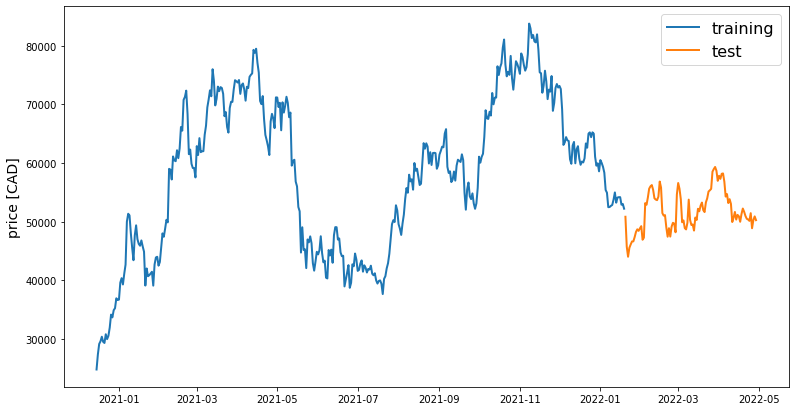

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
#normalizing the dataset into a common scale
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
#function for converting the dataset into window sized data
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
#building a lstm model
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
#setting the parameter values
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 3s 59ms/step - loss: 0.0210 - val_loss: 0.0070
Epoch 2/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0090 - val_loss: 0.0042
Epoch 3/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0087 - val_loss: 0.0038
Epoch 4/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 5/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 6/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 7/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0070 - val_loss: 0.0022
Epoch 8/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 9/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 10/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 11/

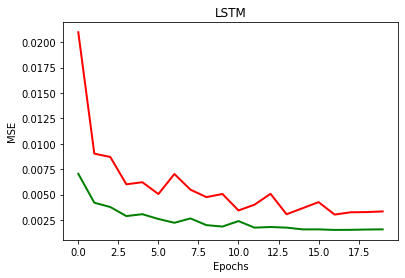

In [ ]:
#Ploting a graph which shows the mse losses in each epoch
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
#Predicting
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.02933841122380239

In [ ]:
#validating
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0015827029417191858

In [ ]:
#percentage of accuaracy
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6423354863911537

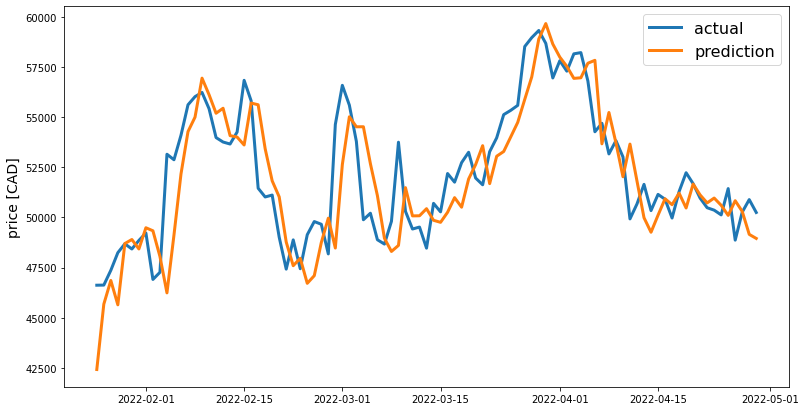

In [ ]:
#Actual vs Predicted graph
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)